In [3]:
# If needed:
# !pip install girder-client pandas python-dateutil tqdm

import os, json, math, time
from datetime import datetime
from dateutil import parser as dateparser
from tqdm import tqdm
from girder_client import GirderClient

# ── Config ─────────────────────────────────────────────────────────────────────
API_URL   = "http://bdsa.pathology.emory.edu:8080/api/v1"

# Choose ONE of these inputs:
FOLDER_ID = "67ddb0782fc8ce397c5ef7fb"   # Example folder; set to None to use explicit IDs
ITEM_IDS  = None                         # e.g. ["673b58d3900c0c0559bf1b76", "68f13d89d26a6d93de13651a", ...]

# Output file
TAG = FOLDER_ID or ("list_" + str(len(ITEM_IDS)) if ITEM_IDS else "ad_hoc")
OUT_JSON = f"items_metadata_annotations_{TAG}.json"

# ── Connect (anonymous or API key from environment) ────────────────────────────
gc = GirderClient(apiUrl=API_URL)
API_KEY = os.getenv("GIRDER_API_KEY")
if API_KEY:
    gc.authenticate(apiKey=API_KEY)

print("Connected to:", API_URL)


Connected to: http://bdsa.pathology.emory.edu:8080/api/v1


In [7]:
# ── Helpers ────────────────────────────────────────────────────────────────────
def iso_dt(s):
    try:
        return dateparser.parse(s).isoformat() if s else None
    except Exception:
        return None

def list_all_items_in_folder(gc: GirderClient, folder_id: str, page_size: int = 100):
    """List all items in a folder with paging."""
    items = []
    offset = 0
    while True:
        batch = list(gc.listItem(folderId=folder_id, limit=page_size, offset=offset))
        if not batch:
            break
        items.extend(batch)
        offset += len(batch)
    return items

def get_item_meta(gc: GirderClient, item_id: str):
    """Return full item meta JSON or 'not available'."""
    try:
        item = gc.get(f"item/{item_id}")
        meta = item.get("meta") or {}
        return meta if meta else "not available"
    except Exception:
        return "not available"

def resolve_user_login(gc: GirderClient, user_id: str):
    """Return 'login' for a given user id; fallback to user 'name'; else None."""
    if not user_id:
        return None
    try:
        u = gc.get(f"user/{user_id}")
        return u.get("login") or u.get("name")
    except Exception:
        return None

def list_all_annotations(gc: GirderClient, item_id: str, page_size: int = 100):
    """
    Return a list of lightweight annotation summaries:
      {_id, name, creator_login, created}
    or "not available" if none present.
    """
    summaries = []
    offset = 0
    while True:
        try:
            anns = gc.get("annotation", parameters={"itemId": item_id, "limit": page_size, "offset": offset})
        except Exception:
            # If the endpoint fails (permissions or otherwise), stop trying and report as not available
            anns = []
        if not anns:
            break

        for doc in anns:
            ann_id = doc.get("_id")
            # Some deployments include 'annotation' embedded (with 'name'), others require fetching the full doc
            name = None
            created = iso_dt(doc.get("created"))
            creator_login = resolve_user_login(gc, doc.get("creatorId"))

            # Try to read embedded name
            if isinstance(doc.get("annotation"), dict):
                name = doc["annotation"].get("name")

            # If we still don't have a name, fetch the full annotation
            if not name and ann_id:
                try:
                    full = gc.get(f"annotation/{ann_id}")
                    if isinstance(full.get("annotation"), dict):
                        name = full["annotation"].get("name")
                    if not creator_login:
                        creator_login = resolve_user_login(gc, full.get("creatorId"))
                    if not created:
                        created = iso_dt(full.get("created"))
                except Exception:
                    pass

            summaries.append({
                "_id": ann_id,
                "name": name or None,
                "creator_login": creator_login,
                "created": created
            })

        if len(anns) < page_size:
            break
        offset += len(anns)

    return summaries if summaries else "not available"

def summarize_item(gc: GirderClient, item_doc: dict):
    """Build the exact JSON output requested for a single item."""
    item_id = item_doc["_id"]
    name    = item_doc.get("name")
    meta    = get_item_meta(gc, item_id)
    anns    = list_all_annotations(gc, item_id)

    return {
        "item_id": item_id,
        "name": name,
        "metadata": meta if meta else "not available",
        "annotations": anns if anns else "not available",
    }


In [8]:
# ── Collect items (from folder or explicit list) ───────────────────────────────
items_source = []
if FOLDER_ID:
    items_source = list_all_items_in_folder(gc, FOLDER_ID)
elif ITEM_IDS:
    # Fetch minimal item docs for each id
    for _id in ITEM_IDS:
        try:
            items_source.append(gc.get(f"item/{_id}"))
        except Exception as e:
            print(f"[WARN] Could not fetch item '{_id}': {e}")
else:
    raise ValueError("Set FOLDER_ID or ITEM_IDS before running.")

print(f"Found {len(items_source)} items.")


Found 9 items.


In [9]:
# ── Build JSON per item (Metadata + Annotations) ───────────────────────────────
results = []
for it in tqdm(items_source, desc="Fetching metadata & annotations"):
    try:
        results.append(summarize_item(gc, it))
    except Exception as e:
        # Include a minimal stub so you can see failures per item
        results.append({
            "item_id": it.get("_id"),
            "name": it.get("name"),
            "metadata": "not available",
            "annotations": "not available",
            "error": str(e)
        })

# Save JSON
with open(OUT_JSON, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved: {OUT_JSON}")
# Show first 1–2 items for sanity
(results[:2] if len(results) > 2 else results)


Fetching metadata & annotations: 100%|██████████| 9/9 [00:00<00:00, 21.04it/s]

Saved: items_metadata_annotations_67ddb0782fc8ce397c5ef7fb.json


[{'item_id': '68d3ee30d26a6d93de10ebfe',
  'name': 'E04-179_ABETA_1I (overlay source)',
  'metadata': 'not available',
  'annotations': 'not available'},
 {'item_id': '68d3f1c2d26a6d93de10ec06',
  'name': 'E04-32_ABETA_2B (overlay source)',
  'metadata': 'not available',
  'annotations': 'not available'}]

In [10]:
import os
import requests
import json
from tqdm import tqdm
from dateutil import parser as dateparser

# 1. API & Authentication
API_URL = "http://bdsa.pathology.emory.edu:8080/api/v1"
FOLDER_ID = "67ddb0782fc8ce397c5ef7fb"  # Emory ADRC Cohorts > Bhavesh
TOKEN = "El4DUuufS4TBqxljcjdT4ZaXL7T4uVl7PK9gNigsgAhc9AjBlk5J4CIYAkNSEvsv"  # <--- Replace or use env variable

session = requests.Session()
session.headers.update({
    "Accept": "application/json",
    "Girder-Token": TOKEN
})

# 2. Helper functions
def get_item_metadata(item_id):
    url = f"{API_URL}/item/{item_id}"
    r = session.get(url)
    if r.status_code == 200:
        meta = r.json().get("meta", {})
        return meta if meta else "not available"
    return "not available"

def get_item_annotations(item_id):
    url = f"{API_URL}/annotation"
    params = {"itemId": item_id, "limit": 1000}
    r = session.get(url, params=params)
    if r.status_code == 200:
        data = r.json()
        if not data:
            return "not available"
        return [{
            "annotation_id": ann["_id"],
            "name": ann.get("annotation", {}).get("name"),
            "creator": ann.get("creatorId"),
            "created": dateparser.parse(ann.get("created")).isoformat() if ann.get("created") else None
        } for ann in data]
    return "not available"

def list_folder_items(folder_id):
    url = f"{API_URL}/item"
    items, offset = [], 0
    while True:
        params = {"folderId": folder_id, "limit": 50, "offset": offset}
        r = session.get(url, params=params)
        if r.status_code != 200 or not r.json():
            break
        items.extend(r.json())
        offset += 50
    return items

# 3. Main logic
results = []
items = list_folder_items(FOLDER_ID)

for item in tqdm(items, desc="Processing items"):
    name = item.get("name", "")
    item_id = item["_id"]

    # Skip overlay source items
    if "(overlay source)" in name:
        continue

    metadata = get_item_metadata(item_id)
    annotations = get_item_annotations(item_id)

    results.append({
        "item_id": item_id,
        "name": name,
        "metadata": metadata,
        "annotations": annotations
    })

# 4. Save output
with open("emory_adrc_metadata_annotations.json", "w") as f:
    json.dump(results, f, indent=2)

results[:3]  # show first few entries


Processing items: 100%|██████████| 9/9 [00:00<00:00, 83.47it/s]


[{'item_id': '68cd7f2977dbcb39504b9681',
  'name': 'E04-32_ABETA_2B.svs',
  'metadata': {'bad_image': 'no',
   'npSchema': {'blockID': '2B', 'caseID': 'E04-32', 'stainID': 'aBeta'},
   'wsi_fp': '/wsi_archive/APOLLO_NP/2004/E04-32/E04-32_ABETA_2B.svs'},
  'annotations': [{'annotation_id': '68d3f1c5d26a6d93de10ec09',
    'name': 'PPC overlay (TIFF)',
    'creator': '67aa20fbc2b750cd217c802f',
    'created': '2025-09-24T13:27:33.003000+00:00'}]},
 {'item_id': '68d3f4f3d26a6d93de10ec10',
  'name': 'E04-49_1D_AB.svs',
  'metadata': {'caseID': 'E04-49',
   'fp': '/wsi_archive/APOLLO_NP/2004/E04-49/ScannedSlides/unknown/E04-49_1D_AB.svs',
   'regionName': 'Temporal cortex',
   'stainID': 'aBeta'},
  'annotations': [{'annotation_id': '68d465b5d26a6d93de10ed93',
    'name': 'PPC overlay (TIFF)',
    'creator': '67aa20fbc2b750cd217c802f',
    'created': '2025-09-24T21:42:13.269000+00:00'}]},
 {'item_id': '68cdae8277dbcb39504bbe39',
  'name': 'E07-38_ABETA_1D.svs',
  'metadata': {'bad_image': 'n

In [26]:
# === JUPYTER: Fetch items + metadata + annotations for every image in a folder ===
# Works with token in either response shape:
#   { "_id": "<token>" }   OR   { "authToken": { "token": "<token>" }, "user": {...} }
# Deps: pip install requests pandas python-dateutil tqdm

import json
import requests
import pandas as pd
from dateutil import parser as dateparser

try:
    from tqdm.notebook import tqdm
except Exception:
    from tqdm import tqdm

# --------------------------- EDIT THESE ----------------------------------------
API_URL   = "http://bdsa.pathology.emory.edu:8080/api/v1"     # keep /api/v1
FOLDER_ID = "67ddb0782fc8ce397c5ef7fb"                        # your folder id
API_KEY   = "ge0hXqTSQ3wxSbA6VTdoLkHPv88JFfiABK0ggDkQ"        # <-- YOUR BDSA API KEY
# ------------------------------------------------------------------------------
PAGE_SIZE = 100
TIMEOUT   = 45

def _join(base: str, path: str) -> str:
    return f"{base.rstrip('/')}/{path.lstrip('/')}"

def iso_dt(s):
    try:
        return dateparser.parse(s).isoformat() if s else None
    except Exception:
        return s

def _extract_token(resp_json: dict) -> str | None:
    """
    Accept both Girder token response shapes:
      1) {"_id": "<token>"}                       (older/alt shape)
      2) {"authToken": {"token": "<token>"}, ...} (your server's shape)
    """
    if not isinstance(resp_json, dict):
        return None
    if resp_json.get("_id"):
        return resp_json["_id"]
    auth = resp_json.get("authToken") or {}
    if isinstance(auth, dict) and auth.get("token"):
        return auth["token"]
    return None

def build_session_with_api_key(api_url: str, api_key: str):
    """
    ONLY API key is required. We exchange it for a session token via:
      POST /api_key/token?key=<API_KEY>
    Then we attach 'Girder-Token' for subsequent requests.
    """
    if not api_key:
        print("❌ GIRDER_API_KEY is empty; set API_KEY at the top of the cell.")
        return None

    s = requests.Session()
    s.headers["accept"] = "application/json"

    token_url = _join(api_url, "api_key/token")
    try:
        r = s.post(token_url, params={"key": api_key}, timeout=TIMEOUT)
        if r.status_code == 405:
            # Rare servers might accept GET
            r = s.get(token_url, params={"key": api_key}, timeout=TIMEOUT)
        r.raise_for_status()
        j = r.json()
        token = _extract_token(j)
        if not token:
            print("❌ Token exchange responded but no token field found.\nRaw response:\n", json.dumps(j, indent=2)[:800])
            return None
        s.headers["Girder-Token"] = token
        return s
    except requests.HTTPError:
        print(f"❌ API key → token failed (HTTP {r.status_code}) at {token_url}")
        print(f"   Response (first 400 chars): {r.text[:400]}")
        return None
    except Exception as e:
        print(f"❌ Token exchange error at {token_url} -> {e}")
        return None

def GET(session, path, **kwargs):
    url = _join(API_URL, path)
    return session.get(url, timeout=TIMEOUT, **kwargs)

def verify_me(session):
    r = GET(session, "user/me")
    if r.status_code == 200:
        u = r.json()
        who = u.get("login") or u.get("email") or u.get("_id")
        print(f"✅ Authenticated as: {who}")
    else:
        print(f"ℹ️ /user/me -> HTTP {r.status_code} (continuing)")

def fetch_folder(session, folder_id):
    r = GET(session, f"folder/{folder_id}")
    if r.status_code == 200:
        return r.json()
    print(f"❌ fetch_folder: HTTP {r.status_code} at {r.request.url}")
    return None

def list_items_in_folder(session, folder_id, page_size=PAGE_SIZE):
    items, offset = [], 0
    while True:
        r = GET(session, "item", params={
            "folderId": folder_id,
            "limit": page_size,
            "offset": offset,
            "sort": "lowerName",
            "sortdir": 1
        })
        if r.status_code == 403:
            print("❌ 403 Forbidden listing items (check API key permissions on this folder).")
            return []
        if r.status_code != 200:
            print(f"❌ Listing items failed (HTTP {r.status_code}) at {r.request.url}")
            print(r.text[:300])
            return []
        batch = r.json()
        if not batch:
            break
        items.extend(batch)
        if len(batch) < page_size:
            break
        offset += len(batch)
    return items

def get_item(session, item_id):
    r = GET(session, f"item/{item_id}")
    if r.status_code == 200:
        return r.json()
    if r.status_code == 403:
        return {"_id": item_id, "meta": "not available (403 forbidden - check API key scope)"}
    return {"_id": item_id, "meta": "not available"}

def list_annotations(session, item_id, page_size=PAGE_SIZE):
    anns, offset = [], 0
    while True:
        r = GET(session, "annotation", params={
            "itemId": item_id,
            "limit": page_size,
            "offset": offset,
            "sort": "lowerName",
            "sortdir": 1
        })
        if r.status_code == 403:
            return "not available (403 forbidden - check API key scope)"
        if r.status_code != 200:
            if offset == 0:
                print(f"ℹ️ list_annotations: HTTP {r.status_code} for {r.request.url}")
            break
        batch = r.json()
        if not batch:
            break
        for a in batch:
            anns.append({
                "annotation_id": a.get("_id"),
                "itemId": a.get("itemId"),
                "name": (a.get("annotation") or {}).get("name"),
                "creatorId": a.get("creatorId"),
                "created": iso_dt(a.get("created")),
                "updated": iso_dt(a.get("updated")),
                "elementCount": a.get("_elementCount"),
                "detailsCount": a.get("_detailsCount"),
                "accessLevel": a.get("_accessLevel"),
                "public": a.get("public"),
            })
        if len(batch) < page_size:
            break
        offset += len(batch)
    return anns if anns else "not available"

# ------------------------------ RUN -------------------------------------------
print(f"API_URL -> {_join(API_URL, '')}")
session = build_session_with_api_key(API_URL, API_KEY)
if session is None:
    raise RuntimeError("Unable to authenticate with GIRDER_API_KEY. Fix API_KEY and re-run the cell.")

verify_me(session)

folder = fetch_folder(session, FOLDER_ID)
if folder:
    print(f"📁 Folder: {folder.get('name')} (id={FOLDER_ID})")
else:
    print(f"⚠️ Folder {FOLDER_ID} not found or access denied.")

items = list_items_in_folder(session, FOLDER_ID)
if not items:
    print(f"⚠️ No items found or access denied for folder {FOLDER_ID}.")
    # Emit empty outputs
    with open(f"folder_{FOLDER_ID}_items_with_annotations.json", "w") as f:
        json.dump([], f, indent=2)
    items_df = pd.DataFrame([])
    anns_df  = pd.DataFrame([])
else:
    print(f"🔎 Found {len(items)} items. Fetching details + annotations...")
    rich, item_rows, ann_rows = [], [], []

    for it in tqdm(items):
        item_id = it.get("_id")
        full = get_item(session, item_id)
        meta = full.get("meta", "not available")
        anns = list_annotations(session, item_id)

        rich.append({
            "item": {
                "_id": item_id,
                "name": it.get("name"),
                "description": it.get("description"),
                "size": it.get("size"),
                "created": iso_dt(it.get("created")),
                "updated": iso_dt(it.get("updated")),
                "folderId": it.get("folderId"),
                "viewerUrl": f"{API_URL.replace('/api/v1','')}/#item/{item_id}"
            },
            "metadata": meta if meta else "not available",
            "annotations": anns
        })

        item_rows.append({
            "item_id": item_id,
            "name": it.get("name"),
            "size": it.get("size"),
            "created": iso_dt(it.get("created")),
            "updated": iso_dt(it.get("updated")),
            "metadata_json": json.dumps(meta) if isinstance(meta, dict) else (meta or "not available"),
            "annotation_count": (len(anns) if isinstance(anns, list) else 0),
        })

        if isinstance(anns, list):
            for a in anns:
                ann_rows.append({
                    "item_id": item_id,
                    "item_name": it.get("name"),
                    **a
                })

    # Save outputs
    with open(f"folder_{FOLDER_ID}_items_with_annotations.json", "w") as f:
        json.dump(rich, f, indent=2)

    items_df = pd.DataFrame(item_rows)
    anns_df  = pd.DataFrame(ann_rows)

    items_df.to_csv(f"folder_{FOLDER_ID}_items.csv", index=False)
    anns_df.to_csv(f"folder_{FOLDER_ID}_annotations.csv", index=False)

    print("\n💾 Saved files:")
    print(f"- folder_{FOLDER_ID}_items_with_annotations.json")
    print(f"- folder_{FOLDER_ID}_items.csv")
    print(f"- folder_{FOLDER_ID}_annotations.csv")

# Show a quick preview in the notebook
display(items_df.head(10))
display(anns_df.head(15) if 'anns_df' in globals() else pd.DataFrame([]))


API_URL -> http://bdsa.pathology.emory.edu:8080/api/v1/
✅ Authenticated as: kbhavesh
📁 Folder: Bhavesh (id=67ddb0782fc8ce397c5ef7fb)
🔎 Found 9 items. Fetching details + annotations...


  0%|          | 0/9 [00:00<?, ?it/s]


💾 Saved files:
- folder_67ddb0782fc8ce397c5ef7fb_items_with_annotations.json
- folder_67ddb0782fc8ce397c5ef7fb_items.csv
- folder_67ddb0782fc8ce397c5ef7fb_annotations.csv


,item_id,name,size,created,updated,metadata_json,annotation_count
0,68d3ee30d26a6d93de10ebfe,E04-179_ABETA_1I (overlay source),0,2025-09-24T13:12:16.284000+00:00,2025-09-24T13:12:16.284000+00:00,{},0
1,68d3f1c2d26a6d93de10ec06,E04-32_ABETA_2B (overlay source),217134176,2025-09-24T13:27:30.399000+00:00,2025-09-24T13:27:30.399000+00:00,{},0
2,68cd7f2977dbcb39504b9681,E04-32_ABETA_2B.svs,1197790249,2025-09-19T16:04:57.315000+00:00,2025-09-19T16:04:57.315000+00:00,"{""bad_image"": ""no"", ""npSchema"": {""blockID"": ""2...",1
3,68d40877d26a6d93de10ecc9,E04-49_1D_AB (overlay source),509180136,2025-09-24T15:04:23.061000+00:00,2025-09-24T15:04:23.061000+00:00,{},0
4,68d3f4f3d26a6d93de10ec10,E04-49_1D_AB.svs,2809747959,2025-09-24T13:41:07.780000+00:00,2025-09-24T13:41:07.780000+00:00,"{""caseID"": ""E04-49"", ""fp"": ""/wsi_archive/APOLL...",1
5,68d3fb38d26a6d93de10ecc1,E07-38_ABETA_1D (overlay source),399997996,2025-09-24T14:07:52.697000+00:00,2025-09-24T14:07:52.697000+00:00,{},0
6,68cdae8277dbcb39504bbe39,E07-38_ABETA_1D.svs,964591411,2025-09-19T19:26:58.643000+00:00,2025-09-19T19:26:58.643000+00:00,"{""bad_image"": ""no"", ""npSchema"": {""blockID"": ""1...",1
7,68d40c71d26a6d93de10ecd7,E23-02_4_AB (overlay source),1690986300,2025-09-24T15:21:21.036000+00:00,2025-09-24T15:21:21.036000+00:00,{},0
8,68d3f4f4d26a6d93de10ec50,E23-02_4_AB.svs,5386079705,2025-09-24T13:41:08.685000+00:00,2025-09-24T13:41:08.685000+00:00,"{""caseID"": ""E23-02"", ""fp"": ""/wsi_archive/APOLL...",1


,item_id,item_name,annotation_id,itemId,name,creatorId,created,updated,elementCount,detailsCount,accessLevel,public
0,68cd7f2977dbcb39504b9681,E04-32_ABETA_2B.svs,68d3f1c5d26a6d93de10ec09,68cd7f2977dbcb39504b9681,PPC overlay (TIFF),67aa20fbc2b750cd217c802f,2025-09-24T13:27:33.003000+00:00,2025-09-24T13:27:33.003000+00:00,1,1,2,False
1,68d3f4f3d26a6d93de10ec10,E04-49_1D_AB.svs,68d465b5d26a6d93de10ed93,68d3f4f3d26a6d93de10ec10,PPC overlay (TIFF),67aa20fbc2b750cd217c802f,2025-09-24T21:42:13.269000+00:00,2025-09-24T21:42:13.269000+00:00,1,1,2,False
2,68cdae8277dbcb39504bbe39,E07-38_ABETA_1D.svs,68d3fb3ed26a6d93de10ecc4,68cdae8277dbcb39504bbe39,PPC overlay (TIFF),67aa20fbc2b750cd217c802f,2025-09-24T14:07:58.233000+00:00,2025-09-24T14:07:58.233000+00:00,1,1,2,False
3,68d3f4f4d26a6d93de10ec50,E23-02_4_AB.svs,68d40fb7d26a6d93de10ecda,68d3f4f4d26a6d93de10ec50,PPC overlay (TIFF),67aa20fbc2b750cd217c802f,2025-09-24T15:35:19.784000+00:00,2025-09-24T15:35:19.784000+00:00,1,1,2,False


In [28]:
# === JUPYTER: Items + Metadata + Annotations + Files + Tiles → Excel ===
# Deps: pip install requests pandas python-dateutil tqdm openpyxl

import json
import requests
import pandas as pd
from dateutil import parser as dateparser

try:
    from tqdm.notebook import tqdm
except Exception:
    from tqdm import tqdm

# --------------------------- EDIT THESE ----------------------------------------
API_URL   = "http://bdsa.pathology.emory.edu:8080/api/v1"     # keep /api/v1
FOLDER_ID = "67ddb0782fc8ce397c5ef7fb"                        # your folder id
API_KEY   = "ge0hXqTSQ3wxSbA6VTdoLkHPv88JFfiABK0ggDkQ"        # your BDSA API key
# ------------------------------------------------------------------------------
PAGE_SIZE = 100
TIMEOUT   = 45

def _join(base: str, path: str) -> str:
    return f"{base.rstrip('/')}/{path.lstrip('/')}"

def iso_dt(s):
    try:
        return dateparser.parse(s).isoformat() if s else None
    except Exception:
        return s

def _extract_token(resp_json: dict) -> str | None:
    if not isinstance(resp_json, dict):
        return None
    if resp_json.get("_id"):
        return resp_json["_id"]
    auth = resp_json.get("authToken") or {}
    if isinstance(auth, dict) and auth.get("token"):
        return auth["token"]
    return None

def build_session_with_api_key(api_url: str, api_key: str):
    if not api_key:
        print("❌ GIRDER_API_KEY is empty; set API_KEY at the top of the cell.")
        return None
    s = requests.Session()
    s.headers["accept"] = "application/json"
    token_url = _join(api_url, "api_key/token")
    try:
        r = s.post(token_url, params={"key": api_key}, timeout=TIMEOUT)
        if r.status_code == 405:
            r = s.get(token_url, params={"key": api_key}, timeout=TIMEOUT)
        r.raise_for_status()
        token = _extract_token(r.json())
        if not token:
            print("❌ Token exchange responded but no token field found.\nRaw response:\n", r.text[:800])
            return None
        s.headers["Girder-Token"] = token
        return s
    except requests.HTTPError:
        print(f"❌ API key → token failed (HTTP {r.status_code}) at {token_url}")
        print(f"   Response (first 400 chars): {r.text[:400]}")
        return None
    except Exception as e:
        print(f"❌ Token exchange error at {token_url} -> {e}")
        return None

def GET(session, path, **kwargs):
    url = _join(API_URL, path)
    return session.get(url, timeout=TIMEOUT, **kwargs)

def verify_me(session):
    r = GET(session, "user/me")
    if r.status_code == 200:
        u = r.json()
        who = u.get("login") or u.get("email") or u.get("_id")
        print(f"✅ Authenticated as: {who}")
    else:
        print(f"ℹ️ /user/me -> HTTP {r.status_code} (continuing)")

def fetch_folder(session, folder_id):
    r = GET(session, f"folder/{folder_id}")
    if r.status_code == 200:
        return r.json()
    print(f"❌ fetch_folder: HTTP {r.status_code} at {r.request.url}")
    return None

def list_items_in_folder(session, folder_id, page_size=PAGE_SIZE):
    items, offset = [], 0
    while True:
        r = GET(session, "item", params={
            "folderId": folder_id,
            "limit": page_size,
            "offset": offset,
            "sort": "lowerName",
            "sortdir": 1
        })
        if r.status_code == 403:
            print("❌ 403 Forbidden listing items (check API key permissions on this folder).")
            return []
        if r.status_code != 200:
            print(f"❌ Listing items failed (HTTP {r.status_code}) at {r.request.url}")
            print(r.text[:300])
            return []
        batch = r.json()
        if not batch:
            break
        items.extend(batch)
        if len(batch) < page_size:
            break
        offset += len(batch)
    return items

def get_item(session, item_id):
    r = GET(session, f"item/{item_id}")
    if r.status_code == 200:
        return r.json()
    if r.status_code == 403:
        return {"_id": item_id, "meta": "not available (403 forbidden - check API key scope)"}
    return {"_id": item_id, "meta": "not available"}

def list_annotations(session, item_id, page_size=PAGE_SIZE):
    anns, offset = [], 0
    while True:
        r = GET(session, "annotation", params={
            "itemId": item_id,
            "limit": page_size,
            "offset": offset,
            "sort": "lowerName",
            "sortdir": 1
        })
        if r.status_code == 403:
            return "not available (403 forbidden - check API key scope)"
        if r.status_code != 200:
            if offset == 0:
                print(f"ℹ️ list_annotations: HTTP {r.status_code} for {r.request.url}")
            break
        batch = r.json()
        if not batch:
            break
        for a in batch:
            anns.append({
                "annotation_id": a.get("_id"),
                "itemId": a.get("itemId"),
                "name": (a.get("annotation") or {}).get("name"),
                "creatorId": a.get("creatorId"),
                "created": iso_dt(a.get("created")),
                "updated": iso_dt(a.get("updated")),
                "elementCount": a.get("_elementCount"),
                "detailsCount": a.get("_detailsCount"),
                "accessLevel": a.get("_accessLevel"),
                "public": a.get("public"),
            })
        if len(batch) < page_size:
            break
        offset += len(batch)
    return anns if anns else "not available"

def list_files(session, item_id):
    r = GET(session, f"item/{item_id}/files")
    if r.status_code != 200:
        return "not available"
    files = []
    for f in r.json():
        files.append({
            "item_id": item_id,
            "file_id": f.get("_id"),
            "name": f.get("name"),
            "size": f.get("size"),
            "mimeType": f.get("mimeType"),
            "exts": f.get("exts"),
            "created": iso_dt(f.get("created")),
            "updated": iso_dt(f.get("updated")),
        })
    return files if files else "not available"

def get_tiles(session, item_id):
    """
    Returns large-image tile/metadata if available; otherwise 'not available'.
    Example keys: sizeX, sizeY, tileWidth, tileHeight, magnification, levels.
    """
    r = GET(session, f"item/{item_id}/tiles")
    if r.status_code != 200:
        return "not available"
    t = r.json()
    # Flatten a subset of useful fields
    flat = {
        "item_id": item_id,
        "levels": t.get("levels"),
        "tileWidth": t.get("tileWidth"),
        "tileHeight": t.get("tileHeight"),
        "sizeX": t.get("sizeX"),
        "sizeY": t.get("sizeY"),
        "mm_x": t.get("mm_x"),
        "mm_y": t.get("mm_y"),
        "magnification": t.get("magnification"),
        "sourceName": (t.get("source", {}) or {}).get("name") if isinstance(t.get("source"), dict) else t.get("source"),
    }
    return flat

# ------------------------------ RUN -------------------------------------------
print(f"API_URL -> {_join(API_URL, '')}")
session = build_session_with_api_key(API_URL, API_KEY)
if session is None:
    raise RuntimeError("Unable to authenticate with GIRDER_API_KEY. Fix API_KEY and re-run the cell.")

verify_me(session)

folder = fetch_folder(session, FOLDER_ID)
if folder:
    print(f"📁 Folder: {folder.get('name')} (id={FOLDER_ID})")
else:
    print(f"⚠️ Folder {FOLDER_ID} not found or access denied.")

items = list_items_in_folder(session, FOLDER_ID)
if not items:
    print(f"⚠️ No items found or access denied for folder {FOLDER_ID}.")
    # Emit empty outputs
    with open(f"folder_{FOLDER_ID}_items_with_annotations.json", "w") as f:
        json.dump([], f, indent=2)
    items_df = pd.DataFrame([])
    anns_df  = pd.DataFrame([])
    files_df = pd.DataFrame([])
    tiles_df = pd.DataFrame([])
else:
    print(f"🔎 Found {len(items)} items. Fetching details + annotations + files + tiles...")
    rich, item_rows, ann_rows, file_rows, tile_rows = [], [], [], [], []

    for it in tqdm(items):
        item_id = it.get("_id")
        full = get_item(session, item_id)
        meta = full.get("meta", "not available")
        anns = list_annotations(session, item_id)
        files = list_files(session, item_id)
        tiles = get_tiles(session, item_id)

        rich.append({
            "item": {
                "_id": item_id,
                "name": it.get("name"),
                "description": it.get("description"),
                "size": it.get("size"),
                "created": iso_dt(it.get("created")),
                "updated": iso_dt(it.get("updated")),
                "folderId": it.get("folderId"),
                "viewerUrl": f"{API_URL.replace('/api/v1','')}/#item/{item_id}"
            },
            "metadata": meta if meta else "not available",
            "annotations": anns,
            "files": files,
            "tiles": tiles
        })

        item_rows.append({
            "item_id": item_id,
            "name": it.get("name"),
            "size": it.get("size"),
            "created": iso_dt(it.get("created")),
            "updated": iso_dt(it.get("updated")),
            "metadata_json": json.dumps(meta) if isinstance(meta, dict) else (meta or "not available"),
            "annotation_count": (len(anns) if isinstance(anns, list) else 0),
        })

        if isinstance(anns, list):
            for a in anns:
                ann_rows.append({
                    "item_id": item_id,
                    "item_name": it.get("name"),
                    **a
                })

        if isinstance(files, list):
            for f in files:
                file_rows.append(f)

        if isinstance(tiles, dict):
            tile_rows.append(tiles)

    # Save JSON (full nested object)
    with open(f"folder_{FOLDER_ID}_items_with_annotations.json", "w") as f:
        json.dump(rich, f, indent=2)

    # Tabular outputs
    items_df = pd.DataFrame(item_rows)
    anns_df  = pd.DataFrame(ann_rows)
    files_df = pd.DataFrame(file_rows)
    tiles_df = pd.DataFrame(tile_rows)

    # CSVs
    items_df.to_csv(f"folder_{FOLDER_ID}_items.csv", index=False)
    anns_df.to_csv(f"folder_{FOLDER_ID}_annotations.csv", index=False)
    files_df.to_csv(f"folder_{FOLDER_ID}_files.csv", index=False)
    tiles_df.to_csv(f"folder_{FOLDER_ID}_tiles.csv", index=False)

    # Excel workbook with multiple sheets
    xlsx_path = f"folder_{FOLDER_ID}_export.xlsx"
    with pd.ExcelWriter(xlsx_path, engine="openpyxl") as xlw:
        items_df.to_excel(xlw, sheet_name="Items", index=False)
        anns_df.to_excel(xlw, sheet_name="Annotations", index=False)
        files_df.to_excel(xlw, sheet_name="Files", index=False)
        tiles_df.to_excel(xlw, sheet_name="Tiles", index=False)

    print("\n💾 Saved files:")
    print(f"- folder_{FOLDER_ID}_items_with_annotations.json")
    print(f"- folder_{FOLDER_ID}_items.csv")
    print(f"- folder_{FOLDER_ID}_annotations.csv")
    print(f"- folder_{FOLDER_ID}_files.csv")
    print(f"- folder_{FOLDER_ID}_tiles.csv")
    print(f"- {xlsx_path}")

# Quick previews in the notebook
print("\n=== Items preview ===")
display(items_df.head(10))
print("\n=== Annotations preview ===")
display(anns_df.head(10))
print("\n=== Files preview ===")
display(files_df.head(10))
print("\n=== Tiles preview ===")
display(tiles_df.head(10))


API_URL -> http://bdsa.pathology.emory.edu:8080/api/v1/
✅ Authenticated as: kbhavesh
📁 Folder: Bhavesh (id=67ddb0782fc8ce397c5ef7fb)
🔎 Found 9 items. Fetching details + annotations + files + tiles...


  0%|          | 0/9 [00:00<?, ?it/s]


💾 Saved files:
- folder_67ddb0782fc8ce397c5ef7fb_items_with_annotations.json
- folder_67ddb0782fc8ce397c5ef7fb_items.csv
- folder_67ddb0782fc8ce397c5ef7fb_annotations.csv
- folder_67ddb0782fc8ce397c5ef7fb_files.csv
- folder_67ddb0782fc8ce397c5ef7fb_tiles.csv
- folder_67ddb0782fc8ce397c5ef7fb_export.xlsx

=== Items preview ===


,item_id,name,size,created,updated,metadata_json,annotation_count
0,68d3ee30d26a6d93de10ebfe,E04-179_ABETA_1I (overlay source),0,2025-09-24T13:12:16.284000+00:00,2025-09-24T13:12:16.284000+00:00,{},0
1,68d3f1c2d26a6d93de10ec06,E04-32_ABETA_2B (overlay source),217134176,2025-09-24T13:27:30.399000+00:00,2025-09-24T13:27:30.399000+00:00,{},0
2,68cd7f2977dbcb39504b9681,E04-32_ABETA_2B.svs,1197790249,2025-09-19T16:04:57.315000+00:00,2025-09-19T16:04:57.315000+00:00,"{""bad_image"": ""no"", ""npSchema"": {""blockID"": ""2...",1
3,68d40877d26a6d93de10ecc9,E04-49_1D_AB (overlay source),509180136,2025-09-24T15:04:23.061000+00:00,2025-09-24T15:04:23.061000+00:00,{},0
4,68d3f4f3d26a6d93de10ec10,E04-49_1D_AB.svs,2809747959,2025-09-24T13:41:07.780000+00:00,2025-09-24T13:41:07.780000+00:00,"{""caseID"": ""E04-49"", ""fp"": ""/wsi_archive/APOLL...",1
5,68d3fb38d26a6d93de10ecc1,E07-38_ABETA_1D (overlay source),399997996,2025-09-24T14:07:52.697000+00:00,2025-09-24T14:07:52.697000+00:00,{},0
6,68cdae8277dbcb39504bbe39,E07-38_ABETA_1D.svs,964591411,2025-09-19T19:26:58.643000+00:00,2025-09-19T19:26:58.643000+00:00,"{""bad_image"": ""no"", ""npSchema"": {""blockID"": ""1...",1
7,68d40c71d26a6d93de10ecd7,E23-02_4_AB (overlay source),1690986300,2025-09-24T15:21:21.036000+00:00,2025-09-24T15:21:21.036000+00:00,{},0
8,68d3f4f4d26a6d93de10ec50,E23-02_4_AB.svs,5386079705,2025-09-24T13:41:08.685000+00:00,2025-09-24T13:41:08.685000+00:00,"{""caseID"": ""E23-02"", ""fp"": ""/wsi_archive/APOLL...",1



=== Annotations preview ===


,item_id,item_name,annotation_id,itemId,name,creatorId,created,updated,elementCount,detailsCount,accessLevel,public
0,68cd7f2977dbcb39504b9681,E04-32_ABETA_2B.svs,68d3f1c5d26a6d93de10ec09,68cd7f2977dbcb39504b9681,PPC overlay (TIFF),67aa20fbc2b750cd217c802f,2025-09-24T13:27:33.003000+00:00,2025-09-24T13:27:33.003000+00:00,1,1,2,False
1,68d3f4f3d26a6d93de10ec10,E04-49_1D_AB.svs,68d465b5d26a6d93de10ed93,68d3f4f3d26a6d93de10ec10,PPC overlay (TIFF),67aa20fbc2b750cd217c802f,2025-09-24T21:42:13.269000+00:00,2025-09-24T21:42:13.269000+00:00,1,1,2,False
2,68cdae8277dbcb39504bbe39,E07-38_ABETA_1D.svs,68d3fb3ed26a6d93de10ecc4,68cdae8277dbcb39504bbe39,PPC overlay (TIFF),67aa20fbc2b750cd217c802f,2025-09-24T14:07:58.233000+00:00,2025-09-24T14:07:58.233000+00:00,1,1,2,False
3,68d3f4f4d26a6d93de10ec50,E23-02_4_AB.svs,68d40fb7d26a6d93de10ecda,68d3f4f4d26a6d93de10ec50,PPC overlay (TIFF),67aa20fbc2b750cd217c802f,2025-09-24T15:35:19.784000+00:00,2025-09-24T15:35:19.784000+00:00,1,1,2,False



=== Files preview ===


,item_id,file_id,name,size,mimeType,exts,created,updated
0,68d3f1c2d26a6d93de10ec06,68d3f1c4d26a6d93de10ec08,E04-32_ABETA_2B.tiff,217134176,image/tiff,[tiff],2025-09-24T13:27:32.830000+00:00,None
1,68cd7f2977dbcb39504b9681,68cd7f2977dbcb39504b9682,E04-32_ABETA_2B.svs,1197790249,None,[svs],2024-11-11T02:52:59.873000+00:00,None
2,68d40877d26a6d93de10ecc9,68d465b4d26a6d93de10ed92,E04-49_1D_AB.tiff,509180136,image/tiff,[tiff],2025-09-24T21:42:12.982000+00:00,None
3,68d3f4f3d26a6d93de10ec10,68d3f4f3d26a6d93de10ec11,E04-49_1D_AB.svs,2809747959,None,[svs],2024-11-11T02:45:31.306000+00:00,None
4,68d3fb38d26a6d93de10ecc1,68d3fb3ed26a6d93de10ecc3,E07-38_ABETA_1D.tiff,399997996,image/tiff,[tiff],2025-09-24T14:07:58.034000+00:00,None
5,68cdae8277dbcb39504bbe39,68cdae8277dbcb39504bbe3a,E07-38_ABETA_1D.svs,964591411,None,[svs],2024-11-11T00:28:42.060000+00:00,None
6,68d40c71d26a6d93de10ecd7,68d40fb7d26a6d93de10ecd9,E23-02_4_AB.tiff,1690986300,image/tiff,[tiff],2025-09-24T15:35:19.523000+00:00,None
7,68d3f4f4d26a6d93de10ec50,68d3f4f4d26a6d93de10ec51,E23-02_4_AB.svs,5386079705,None,[svs],2024-11-11T07:45:06.254000+00:00,None



=== Tiles preview ===


,item_id,levels,tileWidth,tileHeight,sizeX,sizeY,mm_x,mm_y,magnification,sourceName
0,68d3f1c2d26a6d93de10ec06,9,256,256,59760,45058,NaN,NaN,NaN,None
1,68cd7f2977dbcb39504b9681,9,240,240,59760,45058,0.000502,0.000502,20.0,None
2,68d40877d26a6d93de10ecc9,11,256,256,137447,64150,NaN,NaN,NaN,None
3,68d3f4f3d26a6d93de10ec10,11,240,240,137447,64150,0.000252,0.000252,40.0,None
4,68d3fb38d26a6d93de10ecc1,9,256,256,57768,43055,NaN,NaN,NaN,None
5,68cdae8277dbcb39504bbe39,9,240,240,57768,43055,0.000502,0.000502,20.0,None
6,68d40c71d26a6d93de10ecd7,10,256,256,107567,85344,NaN,NaN,NaN,None
7,68d3f4f4d26a6d93de10ec50,10,240,240,107567,85344,0.000252,0.000252,40.0,None


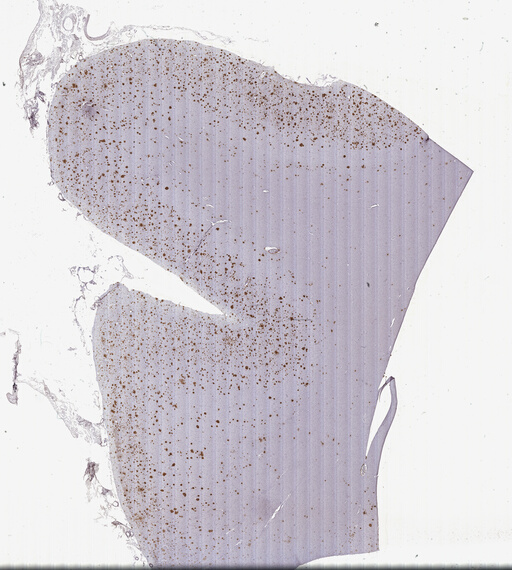

✅ Saved thumbnail to: thumbnail_6105948c68f4fe34fca1bf7c.jpg


In [ ]:
# === JUPYTER: Fetch & display a Girder large_image thumbnail for an item ===
 

import io
import json
import requests
from PIL import Image
from IPython.display import display

# ------------------- EDIT THESE -------------------
API_URL  = "https://styx.neurology.emory.edu/girder/api/v1"   # keep /api/v1
ITEM_ID  = "6105948c68f4fe34fca1bf7c"                         # your example
API_KEY  = ""  # if required on this server, paste key here; else leave empty
# Thumbnail parameters (adjust as you like)
THUMB_WIDTH   = 512        # pixels; set None to omit
THUMB_HEIGHT  = None       # pixels; set e.g. 512 to force WxH
THUMB_FORMAT  = "JPEG"     # "JPEG" or "PNG"
SAVE_PATH     = f"thumbnail_{ITEM_ID}.{ 'jpg' if THUMB_FORMAT.upper()=='JPEG' else 'png'}"
# --------------------------------------------------

def _join(base: str, path: str) -> str:
    return f"{base.rstrip('/')}/{path.lstrip('/')}"

def _extract_token(resp_json: dict) -> str | None:
    """Accept either {'_id': token} or {'authToken': {'token': token}, ...}."""
    if not isinstance(resp_json, dict):
        return None
    if resp_json.get("_id"):
        return resp_json["_id"]
    auth = resp_json.get("authToken") or {}
    if isinstance(auth, dict) and auth.get("token"):
        return auth["token"]
    return None

def build_session(api_url: str, api_key: str | None = None) -> requests.Session:
    s = requests.Session()
    s.headers["accept"] = "application/json"

    if api_key:
        token_url = _join(api_url, "api_key/token")
        r = s.post(token_url, params={"key": api_key}, timeout=30)
        if r.status_code == 405:  # fallback if server only allows GET
            r = s.get(token_url, params={"key": api_key}, timeout=30)
        r.raise_for_status()
        token = _extract_token(r.json())
        if not token:
            raise RuntimeError(f"API key exchange did not return a token.\nResponse: {r.text[:400]}")
        s.headers["Girder-Token"] = token
    return s

def fetch_thumbnail(api_url: str, item_id: str, api_key: str | None = None,
                    width: int | None = 512, height: int | None = None,
                    encoding: str = "JPEG") -> bytes:
    s = build_session(api_url, api_key if api_key else None)
    params = {}
    if width is not None:  params["width"]  = int(width)
    if height is not None: params["height"] = int(height)
    if encoding:           params["encoding"] = encoding.upper()  # "JPEG" or "PNG"

    url = _join(api_url, f"item/{item_id}/tiles/thumbnail")
    r = s.get(url, params=params, timeout=60)
    if r.status_code != 200:
        # Show a helpful message if the server returned JSON error
        ctype = r.headers.get("content-type", "")
        if "application/json" in ctype:
            try:
                print("Server error:", json.dumps(r.json(), indent=2))
            except Exception:
                print("Server error (non-JSON body):", r.text[:500])
        r.raise_for_status()
    return r.content

# ---- Run it ----
thumb_bytes = fetch_thumbnail(API_URL, ITEM_ID, API_KEY, THUMB_WIDTH, THUMB_HEIGHT, THUMB_FORMAT)

# Save to disk
with open(SAVE_PATH, "wb") as f:
    f.write(thumb_bytes)

# Display inline
img = Image.open(io.BytesIO(thumb_bytes))
display(img)

print(f"✅ Saved thumbnail to: {SAVE_PATH}")
